# word2vec (Skipgram)

## 1.Load data

### import library

In [1]:
import numpy as np 
import torch 
import torch.nn as nn
import torch.optim as optim 
import matplotlib.pyplot as plt 
import spacy
import pandas as pd 
import time 
import itertools
from numpy import dot
from numpy.linalg import norm
nlp = spacy.load("en_core_web_sm")

### Load corpus data from text file

In [2]:
f = ((open("questions-words.txt", "r")).read()).split(":")
corpus_syntactic = (f[14]).split("\n")[1:-1] # Singular and Plural Verbs
corpus_semantic = (f[3]).split("\n")[1:-1] + (f[5]).split("\n")[1:-1] # Family [boy, girl, brother, sister]

#if you want to train with all word uncomment this
# corpus = [(f[i-1]).split("\n")[1:-1] for i in range(len(f))]
# word = [[item] for sublist in corpus for item in sublist]

corpus = corpus_semantic + corpus_syntactic #All corpus
word = [[corpus[i]] for i in range(len(corpus))] #extract the data

corpus_syntactic = [[corpus_syntactic[i]] for i in range(len(corpus_syntactic))] #contain the corpus in list
corpus_semantic = [[corpus_semantic[i]] for i in range(len(corpus_semantic))]

In [3]:
len(word) #number of group of word

2241

## 2.Tokenization

In [4]:
def tokenize(corpus_input) : #Tokenize function by using spacy
    corpus_tokenizedd = []
    for token in corpus_input : 
        spare = []
        for ss in nlp(str(token[0])) :
            spare.append(str(ss))
        corpus_tokenizedd.append(spare)    
    return corpus_tokenizedd  

In [5]:
corpus_tokenized = tokenize(word)
cor_sem_token = tokenize(corpus_semantic) # Tokenize the data that use to test syntactic and semantic accuracy
cor_syn_token = tokenize(corpus_syntactic)

Affter tokenize data with look like this krub  ```[['boy', 'girl', 'brother', 'sister'], ['boy', 'girl', 'brothers', 'sisters']]```

In [6]:
flatten = lambda l: [item for sublist in l for item in sublist]
vocabs  = list(set(flatten(corpus_tokenized)))
vocabs_syn  = list(set(flatten(cor_syn_token)))
vocabs_sem  = list(set(flatten(cor_sem_token)))

In [7]:
vocabs[0:5] #show example of vocabs

['shuffles', 'India', 'real', 'woman', 'dad']

## 3.Numerization

In [8]:
word_2_idx = {v: idx for idx, v in enumerate(vocabs)}
vocabs.append('<UNK>')
word_2_idx['<UNK>'] = len(word_2_idx) 

In [9]:
dict(itertools.islice(word_2_idx.items(), 10)) #

{'shuffles': 0,
 'India': 1,
 'real': 2,
 'woman': 3,
 'dad': 4,
 'stepdaughter': 5,
 'dinar': 6,
 'lev': 7,
 'policeman': 8,
 'daughter': 9}

## 4.Prepare data

In [10]:
def random_batch_skipgram(batch_size, corpus_tokenized):
    
    Skipgram = []

    #for each corpus
    for sent in corpus_tokenized:
        try :
            for i in range(1, len(sent) - 1): #start from 1 to second last
                center_word = word_2_idx[sent[i]]
                outside_words = [word_2_idx[sent[i-1]], word_2_idx[sent[i+1]]]  #window_size = 1
                for o in outside_words:
                    Skipgram.append([center_word, o]) #use outside word to predict center word
        except :
            pass               
    #only get a batch, not the entire list
    random_inputs, random_labels = [], []   
    random_index = np.random.choice(range(len(Skipgram)), batch_size, replace=False)
             
    #appending some list of inputs and labels
    for index in random_index:
        random_inputs.append([Skipgram[index][0]])  
        random_labels.append([Skipgram[index][1]])
        
    return np.array(random_inputs), np.array(random_labels)

## 5.Model

In [11]:
class Skipgram(nn.Module):
    
    def __init__(self, voc_size, emb_size):
        super(Skipgram, self).__init__()
        self.embedding_center_word  = nn.Embedding(voc_size, emb_size)  
        self.embedding_outside_word = nn.Embedding(voc_size, emb_size)
    
    def forward(self, center_word, outside_word, all_vocabs):
        #convert them into embedding
        center_word_embed  = self.embedding_center_word(center_word)     #(batch_size, 1, emb_size)
        outside_word_embed = self.embedding_outside_word(outside_word)   #(batch_size, 1, emb_size)
        all_vocabs_embed   = self.embedding_outside_word(all_vocabs)     #(batch_size, voc_size, emb_size)
        top_term = outside_word_embed.bmm(center_word_embed.transpose(1, 2)).squeeze(2)
        top_term_exp = torch.exp(top_term) 
        lower_term = all_vocabs_embed.bmm(center_word_embed.transpose(1, 2)).squeeze(2)
        lower_term_sum = torch.sum(torch.exp(lower_term), 1) 
        loss_fn = -torch.mean(torch.log(top_term_exp / lower_term_sum))

        
        return loss_fn

## 6. Train

In [12]:
voc_size = len(vocabs) #Size of vocabs
batch_size = 2 #Batch size 
emb_size   = 3 #Embeading size of 3
Skipgram   = Skipgram(voc_size, emb_size)
optimizer  = optim.Adam(Skipgram.parameters(), lr=0.001108)
num_epochs = 5000

In [13]:
def prepare_sequence(seq, word2index):
    #map will look at each of element in this list, and apply this function
    idxs = list(map(lambda w: word2index[w] if word2index.get(w) is not None else word2index["<UNK>"], seq))
    return torch.LongTensor(idxs)

all_vocabs = prepare_sequence(list(vocabs), word_2_idx).expand(batch_size, voc_size)
all_vocabs.shape #Shape of vocabs

torch.Size([2, 165])

In [14]:
def epoch_time(start_time, end_time):
    elapsed_time = (end_time - start_time)
    return elapsed_time

In [15]:
run_time_normal = 0
sum_time = 0
#for epoch
for epoch in range(num_epochs):
    start_time = time.time()

    #get random batch
    input_batch, label_batch = random_batch_skipgram(batch_size, corpus_tokenized)
    input_batch = torch.LongTensor(input_batch)
    label_batch = torch.LongTensor(label_batch)
    
    
    #loss = model
    
    optimizer.zero_grad()
    loss = Skipgram(input_batch, label_batch, all_vocabs)
    #backpropagate
    loss.backward()
    #update alpha
    optimizer.step()
    stop_time = time.time()
    run_time_normal = run_time_normal + epoch_time(start_time, stop_time)
    
    #print epoch loss
    if (epoch + 1) % 1000 == 0:
        sum_time += run_time_normal
        print(f"Epoch {epoch+1} | Loss: {loss:.6f} | Time: {run_time_normal} s")
        run_time_normal = 0
print(f"sumary of time is : {sum_time} " )    

Epoch 1000 | Loss: 4.688521 | Time: 13.008969783782959 s
Epoch 2000 | Loss: 5.949137 | Time: 11.941396474838257 s
Epoch 3000 | Loss: 4.482249 | Time: 13.123478889465332 s
Epoch 4000 | Loss: 5.241226 | Time: 12.881953477859497 s
Epoch 5000 | Loss: 3.518096 | Time: 11.065836191177368 s
sumary of time is : 62.02163481712341 


## 7. Visualize Data (PCA)

In [16]:
def get_embed(word , model):
    
    try:
        index = word_2_idx[word]
    except:
        index = word_2_idx['<UNK>']
    
    word = torch.LongTensor([index])
    center_embed  = model.embedding_center_word(word)
    outside_embed = model.embedding_outside_word(word)
    embed = (center_embed + outside_embed) / 2
    
    return  [embed[0][i].item() for i in range(emb_size)]


In [17]:
words = []
for i, word in enumerate(vocabs[:40]): #loop each unique vocab
    words.append(word)
vec_word  = []


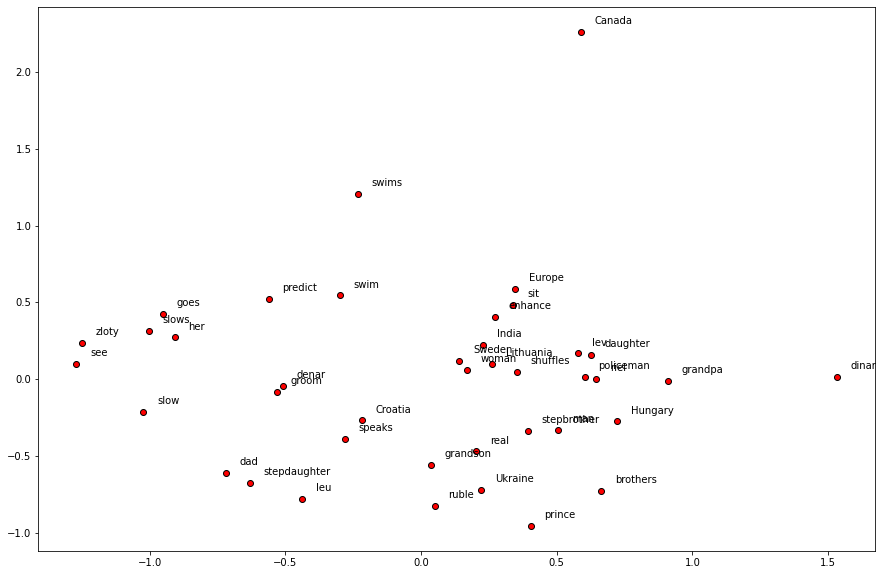

In [18]:
from sklearn.decomposition import PCA
import numpy as np
import matplotlib.pyplot as plt
for oo in words :
    vec_word.append(np.array(get_embed(oo, Skipgram)))
word_vectors = vec_word
twodim = PCA().fit_transform(word_vectors)[:,:2]  #transform 4 to 2 dimensions

plt.figure(figsize=(15,10))
plt.scatter(twodim[:,0], twodim[:,1], edgecolors='k', c='r')
for word, (x,y) in zip(words, twodim):
    plt.text(x+0.05, y+0.05, word)
plt.show()

## 8. Analogy

#### **“man is to king as woman is to queen”**

<img style="float: center;" src="https://carl-allen.github.io/assets/analogy/parallelogram2.svg">

Convert all token into dictionary ```{Token : embedding of token}```

In [19]:
vectors = { token:np.array(get_embed(token, Skipgram)) for token in vocabs } # write function to contain {token : array of token}
vectors_sementic = { token:np.array(get_embed(token, Skipgram)) for token in vocabs_sem } #Convert this use for test accuracy
vectors_syntactic = { token:np.array(get_embed(token, Skipgram)) for token in vocabs_syn }

In [20]:
dict(itertools.islice(vectors_sementic.items(), 5)) # show example of dictionary

{'India': array([0.01257113, 1.07046187, 1.12137079]),
 'real': array([-0.30067906, -0.53136969, -0.04121489]),
 'woman': array([-0.04307298, -0.05996658, -0.18598194]),
 'dad': array([ 0.48874038, -0.7048775 ,  0.60421485]),
 'stepdaughter': array([ 0.37426513, -0.93199003,  0.32094011])}

In [21]:
sum = (vectors["dad"]-vectors["mom"])+vectors["brothers"]

In [22]:
sum_value = np.dot(sum, vectors["brothers"]) / (np.linalg.norm(sum) * np.linalg.norm(vectors["brothers"]))
print(f" 'dad' - 'mom' + 'brothers' similarity to 'sister'  at {sum_value*100} percentage")

 'dad' - 'mom' + 'brothers' similarity to 'sister'  at 74.79303207279048 percentage


In [23]:
def analogy(x1, x2, y1, vectors): 
    x1_vec, x2_vec, y1_vec = vectors[x1], vectors[x2], vectors[y1]
    result_vec = y1_vec + (x2_vec - x1_vec)
    result = closest_word(result_vec, vectors)
    return result

# function to find closest word to a given vector
def closest_word(vec, vectors):
    closest_idx = np.argmax([cosine_similarity(vec, v) for v in vectors.values()]) # use argmax to find the index of 
    return list(vectors.keys())[closest_idx]

# function to calculate cosine similarity
def cosine_similarity(v1, v2):
    return np.dot(v1, v2) / (np.linalg.norm(v1) * np.linalg.norm(v2))

this code ``` np.argmax([cosine_similarity(vec, v) for v in vectors.values()] ``` use to find the most similarity from the result vector to vector of all vocabs

In [24]:
def test_senario(a1 , a2, model_l) :
    tester1 = get_embed(a1, model_l)
    teater2 = get_embed(a2, model_l)
    print(f"{a1} similarity to {a2} = {cosine_similarity(tester1 , teater2)}")

In [25]:
test_senario("king","queen" , Skipgram)

king similarity to queen = 0.9159266752049965


In [26]:
test_senario("eat","eats", Skipgram)


eat similarity to eats = -0.9482380799402991


In [27]:
analogy('he', 'she', 'brothers', vectors)

'stepson'

In [28]:
def extract_word(word_m) :
    word_cc = []
    for value in word_m :
        temporary = []
        for indx in range (len(value)) :
            temporary.append(value[indx])
            if int(indx + 1) % int(2) == 0 :
                if temporary not in word_cc :
                    word_cc.append(temporary)
                temporary = []
    return word_cc            
            

In [29]:
semantic_word = extract_word(cor_sem_token) # after extract data will look like this [['boy', 'girl'], .....]
syntactic_word = extract_word(cor_syn_token)

In [30]:
len(syntactic_word)

30

In [31]:
def acc_test (word_test , vector_target) :
    count = 0
    round = 0
    print(f"the correct word is : ")
    for tokens in word_test : # word_cc[0] look like this [decrease , decreases] then i loop and check analogy every word
        word1 = tokens[0]
        word2 = tokens[1]
        for ss in range (len(word_test)) :
            if str(word1) != str(word_test[ss][0]) :
                relt  = analogy( str(word1), str(word2), word_test[ss][0], vector_target)
                round = round+1
                if str(relt) == str(word_test[ss][1]) :
                    print(f'{word1} is to {word2} as {word_test[ss][0]} to {relt}')
                    count = count + 1     
            else : 
                pass        
    accuracy = (abs(count/round)) * 100        
    print(f"test {round} time correct {count} time, you accuracy is {accuracy :.2f} percentage")    
    return accuracy

this dataset have 30 pair of singular and phural verbs. When loop to check with every word should be 900 round but there are 30 pair that repeated.

In [32]:
skipgram_syn_acc = acc_test(syntactic_word, vectors_syntactic)

the correct word is : 
describe is to describes as implement to implements
eat is to eats as generate to generates
eat is to eats as say to says
eat is to eats as vanish to vanishes
eat is to eats as write to writes
enhance is to enhances as implement to implements
enhance is to enhances as vanish to vanishes
go is to goes as play to plays
implement is to implements as enhance to enhances
implement is to implements as listen to listens
increase is to increases as generate to generates
play is to plays as provide to provides
predict is to predicts as play to plays
predict is to predicts as provide to provides
predict is to predicts as swim to swims
see is to sees as generate to generates
shuffle is to shuffles as go to goes
sing is to sings as listen to listens
sit is to sits as vanish to vanishes
slow is to slows as decrease to decreases
slow is to slows as implement to implements
speak is to speaks as write to writes
swim is to swims as play to plays
swim is to swims as talk to talks


In [33]:
skipgram_sem_acc = acc_test(semantic_word, vectors_sementic)

the correct word is : 
Algeria is to dinar as husband to wife
Angola is to kwanza as Europe to euro
Argentina is to peso as Iran to rial
Argentina is to peso as Korea to won
Argentina is to peso as grandpa to grandma
Armenia is to dram as Malaysia to ringgit
Armenia is to dram as his to her
Bulgaria is to lev as India to rupee
Bulgaria is to lev as Sweden to krona
Bulgaria is to lev as USA to dollar
Cambodia is to riel as Russia to ruble
Canada is to dollar as Macedonia to denar
Canada is to dollar as Vietnam to dong
Croatia is to kuna as Korea to won
Croatia is to kuna as grandpa to grandma
Croatia is to kuna as stepfather to stepmother
Europe is to euro as Japan to yen
Europe is to euro as Russia to ruble
Hungary is to forint as Europe to euro
Hungary is to forint as prince to princess
Japan is to yen as Hungary to forint
Korea is to won as grandfather to grandmother
Korea is to won as nephew to niece
Latvia is to lats as Canada to dollar
Lithuania is to litas as Cambodia to riel
Mal

# CBOW

At above i am already Tokenize and numerize the data

## 1. Prepare the data

In [34]:
def random_batch_CBOW(batch_size, corpus_tokenized):
    
    CBOW = []

    #for each corpus
    for sent in corpus_tokenized:
        try :
            for i in range(1, len(sent) - 1): #start from 1 to second last
                center_word = word_2_idx[sent[i]]
                outside_words = [word_2_idx[sent[i-1]], word_2_idx[sent[i+1]]]  #window_size = 1
                for o in outside_words:
                    CBOW.append([o,center_word ]) #use outside word to predict center word
        except :
            pass               
    #only get a batch, not the entire list
    random_inputs, random_labels = [], []   
    random_index = np.random.choice(range(len(CBOW)), batch_size, replace=False)
             
    #appending some list of inputs and labels
    for index in random_index:
        random_inputs.append([CBOW[index][0]])  
        random_labels.append([CBOW[index][1]])
        
    return np.array(random_inputs), np.array(random_labels)

## 2. Model 

In [35]:
class CBOW(nn.Module):
    
    def __init__(self, voc_size, emb_size):
        super(CBOW, self).__init__()
        self.embedding_center_word  = nn.Embedding(voc_size, emb_size)  
        self.embedding_outside_word = nn.Embedding(voc_size, emb_size)
    
    def forward(self, center_word, outside_word, all_vocabs):
        #convert them into embedding
        center_word_embed  = self.embedding_center_word(center_word)     #(batch_size, 1, emb_size)
        outside_word_embed = self.embedding_outside_word(outside_word)   #(batch_size, 1, emb_size)
        all_vocabs_embed   = self.embedding_outside_word(all_vocabs)     #(batch_size, voc_size, emb_size)
        top_term = outside_word_embed.bmm(center_word_embed.transpose(1, 2)).squeeze(2)
        top_term_exp = torch.exp(top_term) 
        lower_term = all_vocabs_embed.bmm(center_word_embed.transpose(1, 2)).squeeze(2)
        lower_term_sum = torch.sum(torch.exp(lower_term), 1) 
        loss_fn = -torch.mean(torch.log(top_term_exp / lower_term_sum))

        
        return loss_fn

## 3.Train

In [36]:
CBOW = CBOW(voc_size, emb_size)
optimizer  = optim.Adam(CBOW.parameters(), lr=0.000108)
run_time_normal = 0
sum_time = 0
#for epoch
for epoch in range(num_epochs):
    start_time = time.time()
    #get random batch
    input_batch, label_batch = random_batch_CBOW(batch_size, corpus_tokenized)
    input_batch = torch.LongTensor(input_batch)
    label_batch = torch.LongTensor(label_batch)
    #loss = model
    optimizer.zero_grad()
    loss = CBOW(input_batch, label_batch, all_vocabs)
    #backpropagate
    loss.backward()
    #update alpha
    optimizer.step()
    stop_time = time.time()
    run_time_normal = run_time_normal + epoch_time(start_time, stop_time)
    
    #print epoch loss
    if (epoch + 1) % 1000 == 0:
        sum_time += run_time_normal
        print(f"Epoch {epoch+1} | Loss: {loss:.6f} | Time: {run_time_normal} s")
        run_time_normal = 0
print(f"sumary of time is : {sum_time} " )   

Epoch 1000 | Loss: 7.976759 | Time: 13.163470983505249 s
Epoch 2000 | Loss: 5.280479 | Time: 12.832464933395386 s
Epoch 3000 | Loss: 5.694965 | Time: 13.01297640800476 s
Epoch 4000 | Loss: 8.660456 | Time: 11.996899366378784 s
Epoch 5000 | Loss: 7.420256 | Time: 12.205422163009644 s
sumary of time is : 63.21123385429382 


In [37]:
vectors_CBOW = { token:np.array(get_embed(token, CBOW)) for token in vocabs } # write function to contain {token : array of token}
CBOW_sementic = { token:np.array(get_embed(token, CBOW)) for token in vocabs_sem }
CBOW_syntactic = { token:np.array(get_embed(token, CBOW)) for token in vocabs_syn }

In [38]:
CBOW_sem_acc = acc_test(semantic_word, CBOW_sementic)

the correct word is : 
Angola is to kwanza as Croatia to kuna
Argentina is to peso as prince to princess
Bulgaria is to lev as Macedonia to denar
Croatia is to kuna as Macedonia to denar
Croatia is to kuna as brother to sister
Hungary is to forint as Mexico to peso
Iran is to rial as Mexico to peso
Korea is to won as brother to sister
Macedonia is to denar as nephew to niece
Malaysia is to ringgit as Europe to euro
Nigeria is to naira as prince to princess
Poland is to zloty as son to daughter
Poland is to zloty as uncle to aunt
Romania is to leu as man to woman
Romania is to leu as nephew to niece
Russia is to ruble as Croatia to kuna
Ukraine is to hryvnia as uncle to aunt
Vietnam is to dong as stepfather to stepmother
brother is to sister as Latvia to lats
dad is to mom as Iran to rial
grandson is to granddaughter as Lithuania to litas
prince is to princess as Latvia to lats
prince is to princess as stepfather to stepmother
sons is to daughters as USA to dollar
stepbrother is to step

In [39]:
CBOW_syn_acc = acc_test(syntactic_word, CBOW_syntactic)

the correct word is : 
describe is to describes as eat to eats
find is to finds as slow to slows
go is to goes as swim to swims
listen is to listens as find to finds
listen is to listens as slow to slows
provide is to provides as eat to eats
scream is to screams as swim to swims
search is to searches as play to plays
sing is to sings as see to sees
test 870 time correct 9 time, you accuracy is 1.03 percentage


# Negative sampling

## 1. Prepare the Negative set

In [40]:
Z = 0.001
unigram_table = []

In [41]:
from collections import Counter
import random
word_count = Counter(flatten(corpus_tokenized))
aa = [c for w, c in word_count.items()]
sumsum = 0
for i in range(len(aa)) :
    sumsum = sumsum + int(aa[i-1])
for vo in vocabs:
    unigram_table.extend([vo] * int(((word_count[vo]/sumsum)**0.75)/Z))    

In [42]:
def prepare_sequence_skip(seq, word2index):
    idxs = list(map(lambda w: word2index[w] if word2index.get(w) is not None else word2index["<UNK>"], seq))
    return torch.LongTensor(idxs)
def negative_sampling(targets, unigram_table, k):
    batch_size = targets.size(0)
    neg_samples = []
    for i in range(batch_size):
        nsample = []
        target_index = targets[i].item()
        while len(nsample) < k: # num of sampling
            neg = random.choice(unigram_table)
            if word_2_idx[neg] == target_index:
                continue
            nsample.append(neg)
        neg_samples.append(prepare_sequence_skip(nsample, word_2_idx).view(1, -1))
    
    return torch.cat(neg_samples)

## 2. Model

In [43]:
class SkipgramNegSampling(nn.Module):
    
    def __init__(self, vocab_size, emb_size):
        super(SkipgramNegSampling, self).__init__()
        self.embedding_center_word  = nn.Embedding(voc_size, emb_size)  
        self.embedding_outside_word = nn.Embedding(voc_size, emb_size)
        self.logsigmoid = nn.LogSigmoid()
                    
    def forward(self, center_words, target_words, negative_words):
        center_embeds = self.embedding_center_word(center_words) 
        target_embeds = self.embedding_outside_word(target_words) 
        neg_embeds    = -self.embedding_outside_word(negative_words) 
        
        positive_score = target_embeds.bmm(center_embeds.transpose(1, 2)).squeeze(2)
        negative_score = neg_embeds.bmm(center_embeds.transpose(1, 2))
        
        loss = self.logsigmoid(positive_score) + torch.sum(self.logsigmoid(negative_score), 1) #Loss Function
                
        return -torch.mean(loss)
    
    def prediction(self, inputs):
        embeds = self.embedding_center_word(inputs)
        
        return embeds

## 3. Training

In [44]:
Skip_Neg = SkipgramNegSampling(voc_size, emb_size)
optimizer_Neg  = optim.Adam(Skip_Neg.parameters(), lr=0.000108)

In [45]:
run_time_negative = 0
sum_time_negative = 0
num_neg        = 15

for epoch in range(num_epochs):
    
    start = time.time()
    input_batch, target_batch = random_batch_skipgram(batch_size, corpus_tokenized)
    input_batch = torch.LongTensor(input_batch)
    target_batch = torch.LongTensor(target_batch)
    negs_batch = negative_sampling(target_batch, unigram_table, num_neg)
    optimizer_Neg.zero_grad()
    loss = Skip_Neg(input_batch, target_batch, negs_batch)
    # epoch_mins, epoch_secs = epoch_time(start, end)
    loss.backward()
    optimizer_Neg.step()
    end = time.time()
    run_time_negative = run_time_negative + epoch_time(start, end)

    if (epoch + 1) % 1000 == 0:
        sum_time_negative += run_time_negative
        print(f"Epoch: {epoch + 1} | loss: {loss:.6f} | time: {run_time_negative} s")
        run_time_negative = 0
print(f"time when run {num_epochs} epoch is : {sum_time_negative} s")     

Epoch: 1000 | loss: 11.648638 | time: 13.28401517868042 s
Epoch: 2000 | loss: 17.590204 | time: 12.833955526351929 s
Epoch: 3000 | loss: 14.443583 | time: 13.135979175567627 s
Epoch: 4000 | loss: 13.937855 | time: 12.897955656051636 s
Epoch: 5000 | loss: 11.454990 | time: 12.801457405090332 s
time when run 5000 epoch is : 64.95336294174194 s


In [46]:
vectors_Neg = { token:np.array(get_embed(token, Skip_Neg)) for token in vocabs } # write function to contain {token : array of token}
Neg_sementic = { token:np.array(get_embed(token, Skip_Neg)) for token in vocabs_sem }
Neg_syntactic = { token:np.array(get_embed(token, Skip_Neg)) for token in vocabs_syn }

In [47]:
Neg_syn_acc = acc_test(syntactic_word, Neg_syntactic)

the correct word is : 
decrease is to decreases as estimate to estimates
enhance is to enhances as say to says
estimate is to estimates as decrease to decreases
go is to goes as shuffle to shuffles
go is to goes as sit to sits
implement is to implements as play to plays
implement is to implements as scream to screams
increase is to increases as write to writes
play is to plays as generate to generates
scream is to screams as say to says
shuffle is to shuffles as describe to describes
shuffle is to shuffles as sit to sits
sing is to sings as find to finds
sit is to sits as slow to slows
talk is to talks as increase to increases
vanish is to vanishes as sit to sits
walk is to walks as find to finds
walk is to walks as write to writes
test 870 time correct 18 time, you accuracy is 2.07 percentage


In [48]:
Neg_sem_acc = acc_test(semantic_word, Neg_sementic)

the correct word is : 
Croatia is to kuna as stepbrother to stepsister
Denmark is to krone as stepbrother to stepsister
Europe is to euro as Korea to won
India is to rupee as prince to princess
Iran is to rial as Latvia to lats
Japan is to yen as prince to princess
Macedonia is to denar as brothers to sisters
Russia is to ruble as India to rupee
Thailand is to baht as stepson to stepdaughter
dad is to mom as Latvia to lats
grandpa is to grandma as Sweden to krona
man is to woman as Denmark to krone
policeman is to policewoman as boy to girl
son is to daughter as stepfather to stepmother
stepbrother is to stepsister as Sweden to krona
stepson is to stepdaughter as Thailand to baht
test 2756 time correct 16 time, you accuracy is 0.58 percentage


# GloVe

##  1. Co-occurrence matrix

Count the occurrences of pair of words using window size of 1

In [49]:
skip_grams = []

#loop through each corpus
for sent in corpus_tokenized:  #['apple', 'banana', 'fruit']
    #loop through each word from 1 to n-1 (because 0 and n has no context window)
    for i in range(1, len(sent)-1):
        target  = sent[i]
        context = [sent[i+1], sent[i-1]]
        #append(i, i+1) and append(i, i-1)
        for c in context:
            skip_grams.append((target, c))

In [50]:
X_ik_skipgram = Counter(skip_grams)

In [51]:
dict(itertools.islice(X_ik_skipgram.items(), 5)) # show example of dictionary

{('dinar', 'Angola'): 1,
 ('dinar', 'Algeria'): 29,
 ('Angola', 'kwanza'): 29,
 ('Angola', 'dinar'): 1,
 ('dinar', 'Argentina'): 1}

## 2. Weighting function 

GloVe includes a weighting function to scale down too frequent words.


In [52]:
def weighting(w_i, w_j, X_ik):
    #check whether the co-occurrences exist between these two words
    try:
        x_ij = X_ik[(w_i, w_j)]
    except:
        x_ij = 1  #if does not exist, set it to 1
                
    x_max = 100 # fixed in paper  #cannot exceed 100 counts
    alpha = 0.75
    
    #if co-occurrence does not exceed 100, scale it based on some alpha
    if x_ij < x_max:
        result = (x_ij/x_max)**alpha  #scale it
    else:
        result = 1  #if is greater than max, set it to 1 maximum
    
    return result

In [53]:
#now apply this weighting to all possible pairs
from itertools import combinations_with_replacement

X_ik = {}  #for keeping the co-occurences
weighting_dic = {} #scaling the percentage of sampling

for bigram in combinations_with_replacement(vocabs, 2):
    if X_ik_skipgram.get(bigram) is not None:  #matches 
        co_occer = X_ik_skipgram[bigram]  #get the count from what we already counted
        X_ik[bigram] = co_occer + 1 # + 1 for stability issue
        X_ik[(bigram[1],bigram[0])] = co_occer+1   #count also for the opposite
    else:
        pass
        
    weighting_dic[bigram] = weighting(bigram[0], bigram[1], X_ik)
    weighting_dic[(bigram[1], bigram[0])] = weighting(bigram[1], bigram[0], X_ik)
    

## 3. Prepare data

In [54]:
import math

def random_batch_glolve(batch_size, word_sequence, skip_grams, X_ik, weighting_dic):
    
    #loop through this skipgram, and change it id  because when sending model, it must number
    skip_grams_id = [(word_2_idx[skip_gram[0]], word_2_idx[skip_gram[1]]) for skip_gram in skip_grams]
    
    #randomly pick "batch_size" indexes
    number_of_choices = len(skip_grams_id)
    random_index = np.random.choice(number_of_choices, batch_size, replace=False) #no repeating indexes among these random indexes
    
    random_inputs = [] #xi, wi (in batches)
    random_labels = [] #xj, wj (in batches)
    random_coocs  = [] #Xij (in batches)
    random_weighting = [] #f(Xij) (in batches)
    #for each of the sample in these indexes
    for i in random_index:
        random_inputs.append([skip_grams_id[i][0]]) #same reason why i put bracket here....
        random_labels.append([skip_grams_id[i][1]])
        
        #get cooc
        #first check whether it exists...
        pair = skip_grams[i]  #e.g., ('banana', 'fruit)
        try:
            cooc = X_ik[pair]
        except:
            cooc = 1 #label smoothing
            
        random_coocs.append([math.log(cooc)])  #1. why log, #2, why bracket -> size ==> (, 1)  #my neural network expects (, 1)
        
        #get weighting
        weighting = weighting_dic[pair]  #why not use try....maybe it does not exist....
        random_weighting.append(weighting)

        
    return np.array(random_inputs), np.array(random_labels), np.array(random_coocs), np.array(random_weighting)
    

## 4. Model

In [55]:
class GloVe(nn.Module):
    
    def __init__(self, vocab_size,embed_size):
        super(GloVe,self).__init__()
        self.embedding_center_word = nn.Embedding(vocab_size, embed_size) # center embedding
        self.embedding_outside_word = nn.Embedding(vocab_size, embed_size) # out embedding
        
        self.v_bias = nn.Embedding(vocab_size, 1)
        self.u_bias = nn.Embedding(vocab_size, 1)
        
    def forward(self, center_words, target_words, coocs, weighting):
        center_embeds = self.embedding_center_word(center_words) # [batch_size, 1, emb_size]
        target_embeds = self.embedding_outside_word(target_words) # [batch_size, 1, emb_size]
        
        center_bias = self.v_bias(center_words).squeeze(1)
        target_bias = self.u_bias(target_words).squeeze(1)
        
        inner_product = target_embeds.bmm(center_embeds.transpose(1, 2)).squeeze(2)
        #[batch_size, 1, emb_size] @ [batch_size, emb_size, 1] = [batch_size, 1, 1] = [batch_size, 1]
        
        #note that coocs already got log
        loss = weighting*torch.pow(inner_product +center_bias + target_bias - coocs, 2)
        
        return torch.sum(loss)

## 5. Training

In [56]:
#for epoch
Glove_model = GloVe(voc_size, emb_size)
optimizer_Neg  = optim.Adam(Glove_model.parameters(), lr=0.000108)
run_time_normal = 0
sum_time = 0
for epoch in range(num_epochs):

    #get random batch
    input, target, cooc, weightin = random_batch_glolve(batch_size, corpus_tokenized, skip_grams, X_ik, weighting_dic)
    input_batch    = torch.LongTensor(input)
    target_batch   = torch.LongTensor(target)
    cooc_batch     = torch.FloatTensor(cooc)
    weightin_batch = torch.FloatTensor(weightin)
    
    
    # print(input_batch.shape, label_batch.shape, cooc_batch.shape, weightin_batch)
    
    #loss = model
    optimizer.zero_grad()
    loss = Glove_model(input_batch, target_batch, cooc_batch, weightin_batch)
    loss.backward()
    #update alpha
    optimizer.step()
    stop_time = time.time()
    run_time_normal = run_time_normal + epoch_time(start_time, stop_time)
    
    #print epoch loss
    if (epoch + 1) % 1000 == 0:
        sum_time += run_time_normal
        print(f"Epoch: {epoch + 1} | loss: {loss:.6f} | time: {run_time_normal} s")
        run_time_normal = 0
print(f"time when run {num_epochs} epoch is : {sum_time} s")   

Epoch: 1000 | loss: 14.904137 | time: 78066.54366350174 s
Epoch: 2000 | loss: 0.412480 | time: 83268.4679172039 s
Epoch: 3000 | loss: 8.942286 | time: 88494.61744999886 s
Epoch: 4000 | loss: 3.579042 | time: 93566.47874951363 s
Epoch: 5000 | loss: 5.421093 | time: 98600.40408110619 s
time when run 5000 epoch is : 441996.5118613243 s


In [57]:
vectors_GloVe = { token:np.array(get_embed(token, Glove_model)) for token in vocabs } # write function to contain {token : array of token}
GloVe_sementic = { token:np.array(get_embed(token, Glove_model)) for token in vocabs_sem }
GloVe_syntactic = { token:np.array(get_embed(token, Glove_model)) for token in vocabs_syn }

In [58]:
GloVe_syn_acc = acc_test(syntactic_word, GloVe_syntactic)

the correct word is : 
eat is to eats as go to goes
estimate is to estimates as slow to slows
go is to goes as eat to eats
speak is to speaks as walk to walks
write is to writes as shuffle to shuffles
test 870 time correct 5 time, you accuracy is 0.57 percentage


In [59]:
GloVe_sem_acc = acc_test(semantic_word, GloVe_sementic)

the correct word is : 
Algeria is to dinar as Macedonia to denar
Algeria is to dinar as Nigeria to naira
Argentina is to peso as Angola to kwanza
Argentina is to peso as brothers to sisters
Argentina is to peso as policeman to policewoman
Armenia is to dram as Macedonia to denar
Canada is to dollar as Nigeria to naira
Croatia is to kuna as stepbrother to stepsister
Hungary is to forint as Mexico to peso
Malaysia is to ringgit as Thailand to baht
Nigeria is to naira as policeman to policewoman
Russia is to ruble as father to mother
Russia is to ruble as son to daughter
Sweden is to krona as Croatia to kuna
Ukraine is to hryvnia as Mexico to peso
USA is to dollar as Nigeria to naira
Vietnam is to dong as Mexico to peso
boy is to girl as brothers to sisters
boy is to girl as father to mother
dad is to mom as Mexico to peso
grandfather is to grandmother as Iran to rial
grandpa is to grandma as policeman to policewoman
grandson is to granddaughter as Croatia to kuna
he is to she as Iran to 

# Corelation

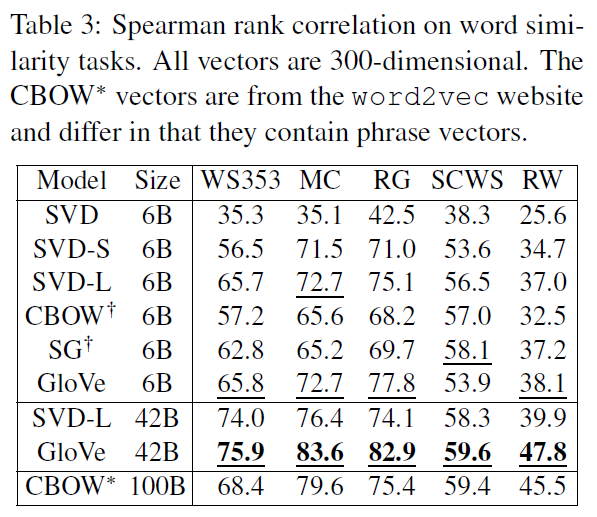

in this paper the researcher use spearman quation to calculate corelation about similarity score between human and model, so i introduce the spearman equation

###  $\rho_s = 1 - \frac{6 \sum d_i^2}{n(n^2-1)}$                         

In [60]:
# Write the equation with numpy
def spearman(x, y):
    # convert input lists to numpy arrays
    x = np.array(x)
    y = np.array(y)
    # calculate rank of x and y
    x_rank = np.argsort(np.argsort(x)) + 1
    y_rank = np.argsort(np.argsort(y)) + 1
    # calculate difference between rank of x and y
    diff = x_rank - y_rank
    # calculate the square of the difference
    diff_sq = diff**2
    # calculate the sum of the square of the difference
    diff_sum = diff_sq.sum()
    # calculate the Spearman rank correlation coefficient
    n = len(x)
    spearman = 1 - ((6*diff_sum) / (n*(n**2 - 1)))
    return spearman

In [79]:
data = pd.read_csv("wordsim_similarity_goldstandard.txt", sep='\t', names=["word1", "word2", "human_score"])
models = [CBOW,Skipgram,Skip_Neg,Glove_model]
corre = []
for i in range(4):
    sim_array = []
    humar_array = []
    
    # data is the dataframe containing the word pairs and human-assigned similarity scores
    for index,row in data.iterrows():
        word1 = row["word1"]
        word2 = row["word2"]
        human_score = row["human_score"]
        if word1 in vocabs and word2 in vocabs:

            center_embeds = get_embed(word1,models[i]) # [batch_size, 1, emb_size]
            target_embeds = get_embed(word2,models[i]) # [batch_size, 1, emb_size]
    #         # Calculate cosin_similarity
            similarity = cosine_similarity(center_embeds,target_embeds)
            sim_array.append(similarity)
            humar_array.append(human_score)

    # # Calculate corelation with spearman Equation
    correlation = spearman(humar_array, sim_array)
    corre.append(correlation)

In [81]:
from tabulate import tabulate
model_name = ["CBOW","Skipgram","Skipgram_Negative","GloVe"]
# creating a DataFrame
dict = {'Name':model_name,
        'Semantic':[CBOW_sem_acc,skipgram_sem_acc,Neg_sem_acc,GloVe_sem_acc],
        'Syntactic':[CBOW_syn_acc,skipgram_syn_acc,Neg_syn_acc,GloVe_syn_acc],
        'Correlation':corre}
df = pd.DataFrame(dict)

# displaying the DataFrame
print(tabulate(df, headers = 'keys', tablefmt = 'psql'))

+----+-------------------+------------+-------------+---------------+
|    | Name              |   Semantic |   Syntactic |   Correlation |
|----+-------------------+------------+-------------+---------------|
|  0 | CBOW              |   0.943396 |    1.03448  |           0   |
|  1 | Skipgram          |   2.39478  |    3.44828  |           0.4 |
|  2 | Skipgram_Negative |   0.580552 |    2.06897  |          -0.4 |
|  3 | GloVe             |   1.30624  |    0.574713 |           1   |
+----+-------------------+------------+-------------+---------------+
